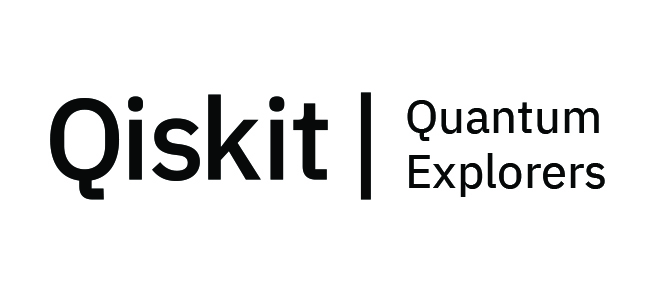

# Introduction to Quantum Neural Network Technqiues
Welcome to Qiskit! Before starting with the exercises, please run the cell below by pressing 'shift' + 'return'.
If there are any packages that you need to install, you can do so with the command:
```!pip install <PACKAGE NAME>``` 
in Jupyter notebook. Please note that qiskit machine learning is a separate package from qiskit.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pylatexenc
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, EfficientSU2
from qiskit.utils import QuantumInstance, algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.datasets import ad_hoc_data, breast_cancer
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN

from IPython.display import clear_output

algorithm_globals.random_seed = 42

In [2]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

## II.1: Using OpflowQNN to train a classification problem using ad hoc data
In this lab we will be exploring neural network methods within the qiskit machine learning module. OpflowQNN is a network based on the evaluation of quantum mechanical observables. OpflowQNN takes a (parametrized) operator from Qiskit and leverages Qiskit’s gradient framework to provide the backward pass. Such an operator can for instance be an expected value of a quantum mechanical observable with respect to a parametrized quantum state. The Parameters can be used to load classical data as well as represent trainable weights. [[1]](https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html#2.-OpflowQNN) In this exercise we will be using the OpflowQNN class to construct a neural network classifier to train and predict on the ad hoc data from the Qiskit machine learning datasets module. The [ad hoc dataset](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.datasets.ad_hoc_data.html#qiskit_machine_learning.datasets.ad_hoc_data) is a toy dataset constructed by sampling uniformly distributed vectors and applying a feature map. Labels are then attributed to vectors according to a pre-defined rule.

First, lets take a look at what this ad hoc dataset actually looks like:

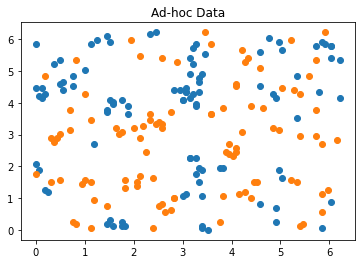

In [3]:
adhoc_feature_dim = 2
adhoc_training_features, adhoc_training_labels_pre, adhoc_test_features, adhoc_test_labels_pre = ad_hoc_data(
    training_size=100, 
    test_size=20, 
    n=adhoc_feature_dim, 
    gap=0.3, 
    plot_data=True
)

### 1.) Convert the labels to be an array of values {-1, +1}
Now that we know what the data looks like, we need to put the data in a usable form for our model. ```adhoc_training_labels``` and ```adhoc_testing_labels``` are currently one hot encoded arrays. In this exercise you will need to convert these one hot encoded labels to be a flat array of values {-1, +1}, where data points in class 0 map to ```-1``` and class 1 maps to ```+1```.

In [4]:
def lab2_ex1(adhoc_training_labels_pre, adhoc_test_labels_pre):
    #
    # FILL IN YOUR CODE HERE
    #
    #
    scaler = MinMaxScaler(feature_range=(-1, 1))
    adhoc_training_labels = scaler.fit_transform(adhoc_training_labels_pre).flatten()
    adhoc_test_labels = scaler.fit_transform(adhoc_test_labels_pre).flatten()

    return adhoc_training_labels, adhoc_test_labels

adhoc_training_labels, adhoc_test_labels = lab2_ex1(adhoc_training_labels_pre, adhoc_test_labels_pre)

Here we construct the TwoLayerQNN class which is a special OpflowQNN on qubits that consists of first a feature map to insert data and second an ansatz that is trained. 

In [5]:
num_inputs=2
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

opflow_qnn.forward(adhoc_training_features[0, :], algorithm_globals.random.random(opflow_qnn.num_weights))

array([[0.25390625]])

A call-back function is used to draw a live plot when the ```.fit()``` method is called.

In [6]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### 2.) Construct the neural network classifier
Now you have all the pieces needed for your neural network, use the ```NeuralNetworkClassifier``` class to create an opflow classifier. Make sure to include the neural network, an optimizer of choice and a callback.

In [7]:
def lab2_ex2(opflow_qnn):
    #
    # FILL IN YOUR CODE HERE
    #
    opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph)
    
    return opflow_classifier

opflow_classifier = lab2_ex2(opflow_qnn)

In [8]:
# here we create an empty array for callback to store evaluations of the objective function when we train our model
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

### 3.) Train the data and predict on the testing set
Now that you have created the classifier, we can start training. Use the ```.fit()``` method to train on the training set, use the ```.score()``` method to see how well the training performed on the training set and finally, use the ```.predict()``` method to predict on the testing set.

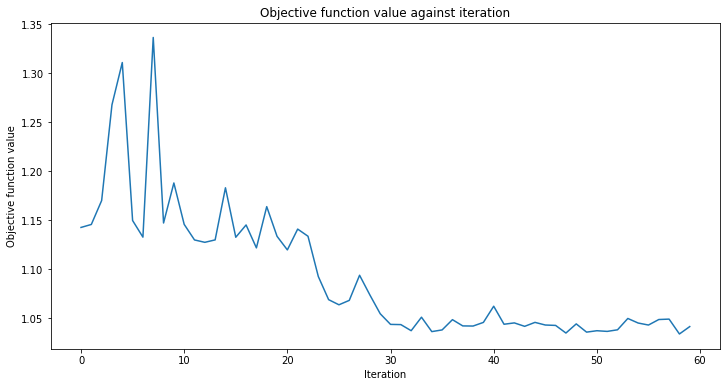

Score of adhoc training data using OpflowQNN: 0.955


In [11]:
def lab2_ex3(opflow_classifier):
    #
    # FILL IN YOUR CODE HERE
    #
    opflow_classifier.fit(adhoc_training_features, adhoc_training_labels[0:adhoc_training_features.shape[0]])
    y_predict = opflow_classifier.predict(adhoc_training_features)
    score_val = opflow_classifier.score(adhoc_training_features, y_predict)

    return score_val
    
score_val = lab2_ex3(opflow_classifier)
print(f'Score of adhoc training data using OpflowQNN: {score_val}')

Now we can take a closer look at where our model went wrong. The below graph plots the testing dataset and outlines in red the data points that the model classified incorrectly. 

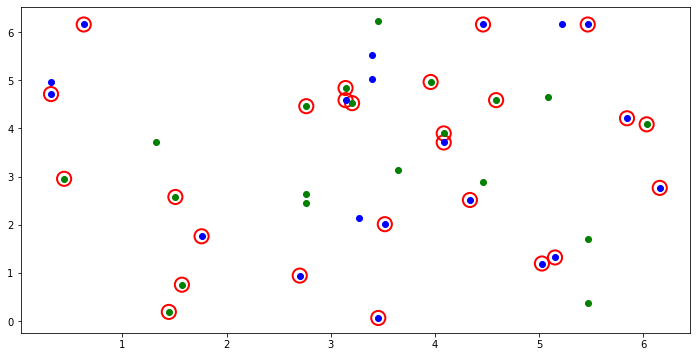

In [13]:
y_predict = opflow_classifier.predict(adhoc_training_features)

for x, y_target, y_p in zip(adhoc_test_features, adhoc_test_labels, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.show()

## II.2: Using CircuitQNN to train a classification problem using ad hoc data
Let's now try another way of training the same datast using CircuitQNN. The CircuitQNN network is based on the samples resulting from measuring a quantum circuit - a (parametrized) QuantumCircuit. This can take input as well as weight parameters and produces samples from the measurement. The samples can either be interpreted as probabilities of measuring the integer index corresponding to a bitstring or directly as a batch of binary output. In the case of probabilities, gradients can be estimated efficiently and the CircuitQNN provides a backward pass as well. [[2]](https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html#4.-CircuitQNN)

### 4.) Choose a feature map and an ansatz
For the CircuitQNN class, we require a feature map and an ansatz to be used. Choose one of Qiskit's feature map and ansatz options. Don't worry if you don't know which one is the best to use: pick one and then see how well your model performs. Once you have run the model and trained it on the data set, if you feel like the accuracy could be improved, then try another combination of feature maps and ansatz. Don't forget to import your chosen parameters from the qiskit library!

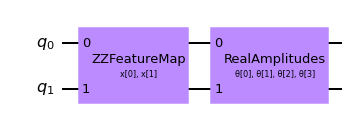

In [14]:
def lab2_ex4(num_inputs):
    #
    # FILL IN YOUR CODE HERE
    #
    feature_map = ZZFeatureMap(num_inputs)
    ansatz = RealAmplitudes(num_inputs, reps=1)

    return feature_map, ansatz

feature_map, ansatz = lab2_ex4(num_inputs)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output="mpl")

We then need to create a parity mapping function to map bitstrings to 0 or 1. The possible outcomes of parity mapping corresponds to the number of classes and the output shape.

In [15]:
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2

### 5.) Construct the CircuitQNN class
Now we have all the pieces needed to construct the CircuitQNN. Create the CircuitQNN and be sure to include the following parameters: ```circuit```, ```input_params```, ```weight_params```, ```interpret```, ```output_shape``` and ```quantum_instance```.

In [16]:
def lab2_ex5(qc, feature_map, ansatz, parity, output_shape, quantum_instance):
    #
    # FILL IN YOUR CODE HERE
    #
    circuit_qnn = CircuitQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        interpret=parity,
        output_shape=output_shape,
        quantum_instance=quantum_instance,
    )
    
    return circuit_qnn

circuit_qnn = lab2_ex5(qc, feature_map, ansatz, parity, output_shape, quantum_instance)

### 6.) Construct the neural network classifier
Now you have all the pieces needed for your neural network, use the ```NeuralNetworkClassifier``` class to create an opflow classifier. Make sure to include the neural network, an optimizer of choice and a callback.

In [17]:
def lab2_ex6(circuit_qnn):
    #
    # FILL IN YOUR CODE HERE
    #
    circuit_classifier = NeuralNetworkClassifier(
        neural_network=circuit_qnn, optimizer=COBYLA(), callback=callback_graph
    )
    return circuit_classifier

circuit_classifier = lab2_ex6(circuit_qnn)

In [18]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

### 7.) Train the data and predict on the testing set
Now that you have created the classifier, we can start training. Use the ```.fit``` method to train on the training set, use the ```.score``` method to see how well the training performed on the training set and finally, use the ```.predict``` method to predict on the testing set.

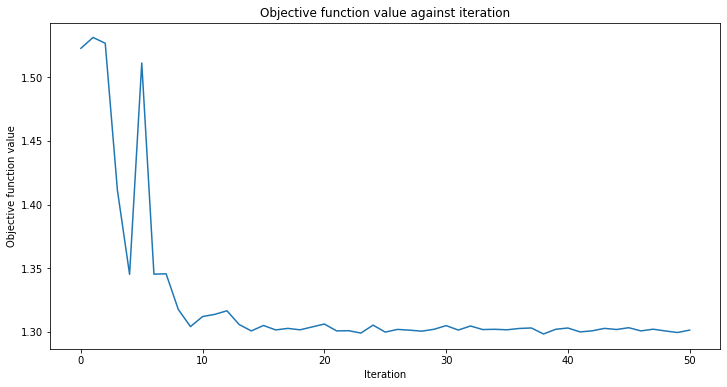

Score of adhoc training data using CircuitQNN: 0.995


In [19]:
def lab2_ex7(circuit_classifier):
    circuit_classifier.fit(adhoc_training_features, adhoc_training_labels[0:adhoc_training_features.shape[0]])
    y_predict = circuit_classifier.predict(adhoc_training_features)
    score_val = circuit_classifier.score(adhoc_training_features, y_predict)
    return score_val

score_val = lab2_ex7(circuit_classifier)
 
print(f'Score of adhoc training data using CircuitQNN: {score_val}')

Again, we can take a closer look at where our model went wrong. The below graph plots the testing dataset and outlines in red the data points that the model classified incorrectly. 

In [78]:
y_predict = circuit_classifier.predict(adhoc_training_features)

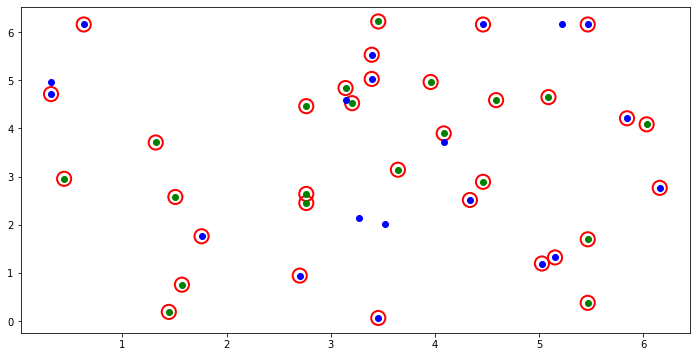

In [21]:
for x, y_target, y_p in zip(adhoc_test_features, adhoc_test_labels, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.show()

Try to change up the various parameters within your model, such as the feature map, ansatz and optimizer to see if you can obtain a better score. Post your accuracy scores on the #q-machine-learning channel in discord!

### 8.) Implement a neural network classifer to train the breast cancer dataset
The qiskit machine learning dataset module contains another classification dataset called breast cancer which you can read more about [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset) and [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). Now that you have tried out two techniques of creating a neural network classifier, have a go at applying the same techniques (or if you are brave trying a new method) to get the highest accuracy score you can on the breast cancer dataset. 

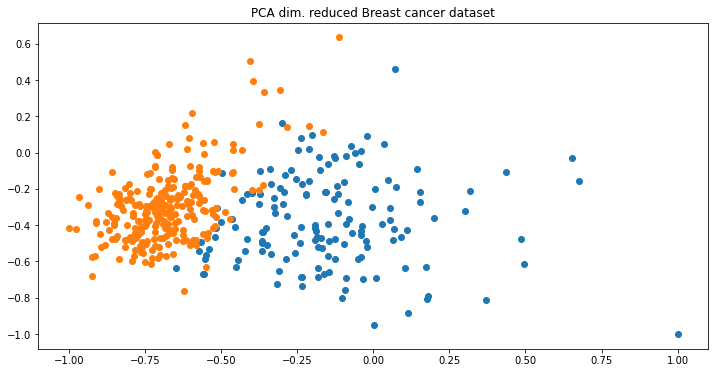

In [65]:
#breast cancer dataset
dimension = 2

training_feature_array, training_label_array, test_feature_array, test_label_array = breast_cancer(
    training_size=300,
    test_size=50,
    n=dimension,
    plot_data=True
)

features = training_feature_array.shape[1]
num_qubits = features

In [66]:
training_feature_array.shape

(398, 2)

In [67]:
training_label_array.shape

(398, 2)

In [68]:
def lab2_ex8():

    ZZ_feature_map = ZZFeatureMap(feature_dimension = features, reps = 1, entanglement = "full")
    
    optimizer = COBYLA(maxiter = 120, tol = 0.001)

    variational_circ = EfficientSU2(num_qubits = num_qubits, reps = 4, entanglement = "full")
    
    backend = Aer.get_backend('statevector_simulator')
    
    quantum_instance = QuantumInstance(backend, 
                                   shots = 1024, 
                                   seed_simulator = algorithm_globals.random_seed, 
                                   seed_transpiler = algorithm_globals.random_seed)
    
    initial_point = algorithm_globals.random.random(variational_circ.num_parameters)
    
    vqc = VQC(feature_map = ZZ_feature_map,
         ansatz = variational_circ,
         optimizer = optimizer,
         quantum_instance = quantum_instance,
         initial_point = initial_point, callback=callback_graph)
    
    return vqc

In [69]:
objective_func_vals = []

In [70]:
model = lab2_ex8()

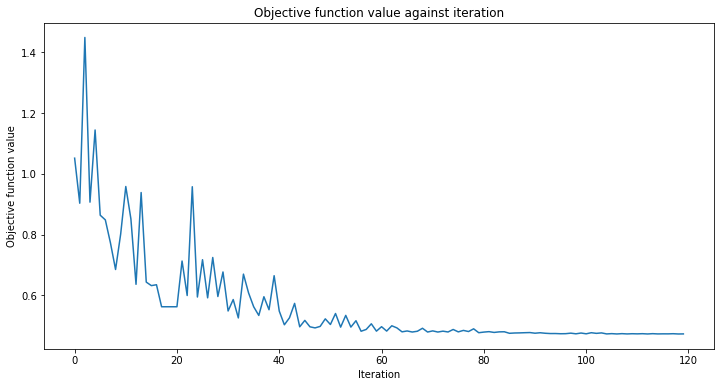

In [71]:
model.fit(training_feature_array, training_label_array)

In [72]:
score_val = model.score(training_feature_array, training_label_array)

print(f'Score of breast cancer training data: {score_val}')

Score of breast cancer training data: 0.9020100502512562


In [73]:
score = model.score(test_feature_array, test_label_array)

print(f"Testing accuracy: {score:0.2f}")

Testing accuracy: 0.85


In [96]:
y_predict = model.predict(training_feature_array).flatten()

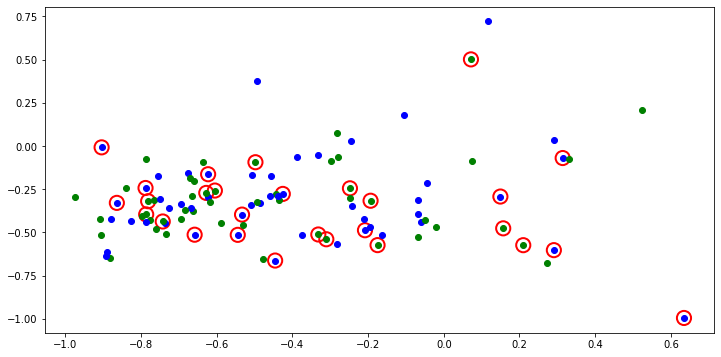

In [97]:
for x, y_target, y_p in zip(test_feature_array, test_label_array.flatten(), y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.show()


<img src="./experiments/imgs/IMG_4707.jpg" width=500px height=500px />